# Задание по курсу "Практическое введение в анализ изображений"

В данном файле приведена заготовка для решения практического задания по курсу "Практическое введение в анализ изображений".

Задание посвящено разработке метода автоматической сегментации минералов на микроскопических изображениях геологических аншлифов. Задание не имеет никаких ограничений по используемым подходам и методам. Тем не менее большинство вещей, расказанных в курсе "Практическое введение в анализ изображений", так или иначе связаны с тематикой задания и могут быть полезны.

Для вашего удобства рекомендуется использовать пакет [`petroscope`](https://github.com/xubiker/petroscope), содержащий набор методов, упрощающих работу с геологическими изображениями. Шаблон решения, приведенный ниже, опирается на этот пакет.

В качестве данных для обучения и тестирование в данном задании используется набор изображений [LumenStone](https://imaging.cs.msu.ru/en/research/geology/lumenstone) (подмножество S1v1.5).

Для начала установим пакет `petroscope`. Сделать это можно двумя способами:
1. Скачать актуальную версию дистрибутива с [GitHub](https://github.com/xubiker/petroscope/releases)
 и выполнить `pip install petroscope-0.0.11-py3-none-any.whl` (поменять номер версии на актуальный)
2. Или же просто выполнить `pip install petroscope`, установив актуальную версию с [PyPI](https://pypi.org/project/petroscope/).

В данном случае воспользуемся более простым способом:

In [1]:
!pip install petroscope --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 2.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached wcwidth-0.2.13-py2.py3-none-any.whl.metadata (14 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.0 MB/s eta 0:00:00a 0:00:01
Using cached packaging-24.2-py3-none-any.whl (65 kB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any

Наш стандартный код для отображения изображений в jupiter notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def show(image, title: str = None, cmap: str = None):
    plt.imshow(image, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

Matplotlib is building the font cache; this may take a moment.


Далее заведем переменную, указывающую путь до датасета LumenStone S1v1.5. Можно залить данные на google drive и примонтировать его к блокноту. Можно запускать все локально.

In [ ]:
from pathlib import Path
ds_path = Path('./LumenStone/S1_v1.5/')

В данном задании мы будем работать с набором изображений LumenStone S1v1.5 (обновленная версия LumenStone S1v1.5). Описание разметки доступно в пакете `petroscope`. Выведем информацию о классах (номер класса, аббревиатура, название, цвет маски):

In [4]:
from petroscope.segmentation.classes import ClassSet, LumenStoneClasses

classset = LumenStoneClasses.S1v1()
for cl in classset.classes:
    print(cl)

[0, bg (background), color: #000000]
[1, ccp/kub (chalcopyrite/cubanite), color: #ffa500]
[2, gl (galena), color: #9acd32]
[4, brt (bornite), color: #00bfff]
[6, py/mrc (pyrite/marcasite), color: #2f4f4f]
[8, sph (sphalerite), color: #ee82ee]
[11, tnt/ttr (tenantite/tetrahedrite), color: #483d8b]


В `petroscope` есть много всего полезного для работы с геологическими изображениями аншлифов. Рассмотрим, напрмиер, открытие изображений и масок.

(2547, 3396, 3) float32


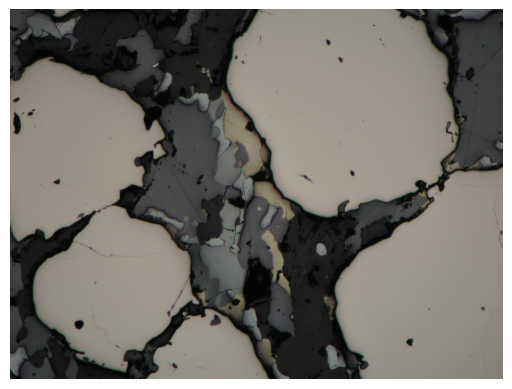

(2547, 3396) uint8
(2547, 3396, 7) float32


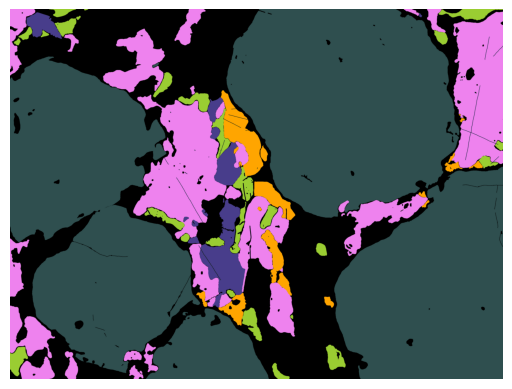

In [5]:
from petroscope.segmentation.utils import load_image, load_mask


img = load_image(ds_path / "imgs/train/train_01.jpg", normalize=True)
print(img.shape, img.dtype)
show(img)

mask = load_mask(ds_path / "masks/train/train_01.png", classes=classset, one_hot=False)
print(mask.shape, mask.dtype)

mask = load_mask(ds_path / "masks/train/train_01.png", classes=classset, one_hot=True)
print(mask.shape, mask.dtype)

mask_colored = load_image(ds_path / "masks_colored_png/train/train_01.png", normalize=False)
show(mask_colored)

Ниже приведен код простейшей (насколько это возможно) модели для сегментации минералов, которая основывается на поиске минерала с ближайшим средним значением цвета из обучающей выборки для каждого пикселя тестового изображения. Ожидаемо, такой подход работает очень плохо. И вам предстоит его улучшить :)


Для реализации нашей модели сегментации отнаследуемся от абстрактного класса GeoSegmModel и реализуем все (ну почти) методы этого абстрактного класса. Это позволит нам использовать пакет ```petroscope``` для вычисления метрик, визуализации предсказаний и карты ошибок на тестовых данных.

In [ ]:
import petroscope.segmentation as segm
from dataclasses import dataclass
from typing import Iterable
import numpy as np
from tqdm import tqdm

class ColorClusterMockModel(segm.GeoSegmModel):

    @dataclass
    class ColorCluster:
        n_pixels: int
        color_mean: np.ndarray

    #hyper parameters
    block_size = 64
    filler_color = [0,0,0] #[-1000, -1000, -1000]
    filler_color_grey = 0 #-1000
    density_minimum = 0.1
    glcm_vector = [4, 1]
    glcm_levels = 256
    glsm_features_count = 4

    def __init__(self, classes: ClassSet) -> None:
        super().__init__()
        self.classes = classes
        self.clusters = dict()



    def load(self, saved_path: Path, **kwargs) -> None:
        raise NotImplementedError

    def calculate_glcm_features(self, image: np.ndarray, num_levels = glcm_levels, dx = glcm_vector[0], dy = glcm_vector[1]) -> np.ndarray:
        #show(image, title='image before', cmap='gray')
        print("image max: ", image.max)
        image = np.floor(image / (256 / num_levels)).astype(int)
        rows, cols = image.shape
        glcm = np.zeros((num_levels, num_levels), dtype=int)
        show(image, title='image after', cmap='gray')
        for i in range(rows - dy):
            for j in range(cols - dx):
                x = image[i, j]
                y = image[i + dy, j + dx]
                #print(x,y)
                if x >= 0 and y >= 0:
                    glcm[x, y] += 1
        #show(glcm, title='GLCM', cmap='gray')
        glcmn = glcm.astype(np.float32) / np.sum(glcm)
        #print(glcmn.shape)
        n = num_levels
        glcmn_2 = glcmn[glcmn > 0]  # Убираем нули
        entropy = -np.sum(glcmn_2 * np.log(glcmn_2))
        contrast = np.sum([(i - j) ** 2 * glcmn[i, j] for i in range(n) for j in range(n)])
        homogeneity = np.sum([glcmn[i, j] / (1 + (i - j) ** 2) for i in range(n) for j in range(n)])
        dissimilarity = np.sum([abs(i - j) * glcmn[i, j] for i in range(n) for j in range(n)])
        #print([entropy, contrast, homogeneity, dissimilarity])
        return [entropy, contrast, homogeneity, dissimilarity] #np.ndarray([entropy, contrast, homogeneity, dissimilarity])

    def train(
        self, img_mask_paths: Iterable[tuple[Path, Path]], **kwargs
    ) -> None:
        for img_p, mask_p in tqdm(img_mask_paths):
            img = load_image(img_p, normalize=True)
            mask = load_mask(mask_p, classes=self.classes, one_hot=False)
            for i in range(0, img.shape[0], self.block_size):
                for j in range(0, img.shape[1], self.block_size):
                    block = img[i:i+self.block_size, j:j+self.block_size]
                    block_mask = mask[i:i+self.block_size, j:j+self.block_size]
                    for code in np.unique(block_mask):
                        density = block[block_mask == code].size / block.size
                        print(density, code)
                        if density >= self.density_minimum and code != 0: #without bg for now
                            #construct and add new element to knn pool:
                            #features_glcm = np.zeros(self.glsm_features_count, dtype=np.float32)
                            grey_block = np.zeros(block_mask.shape, dtype=np.float32)
                            filtered_block = np.zeros(block.shape, dtype=np.float32)
                            for x in range(block.shape[0]):
                                for y in range(block.shape[1]):
                                    if block_mask[x,y] == code:
                                        filtered_block[x,y] = block[x,y]
                                        grey_block[x,y] = 0.2989 * block[x,y,0] + 0.5870 * block[x,y,1] + 0.1140 * block[x,y,2]
                                    else:
                                        filtered_block[x,y] = self.filler_color
                                        grey_block[x,y] = self.filler_color_grey
                            show(block, title='color block')
                            show(grey_block, title='grey block', cmap='gray')
                            features = np.concatenate([self.calculate_glcm_features(grey_block), self.calculate_glcm_features(filtered_block[:,:,0]), self.calculate_glcm_features(filtered_block[:,:,1]), self.calculate_glcm_features(filtered_block[:,:,2])], axis=-1)
                            print(features, code)
                            #block2 = block
                            #block2[block_mask == code] = self.filler_color



            

        

    def predict_image(self, image: np.ndarray) -> np.ndarray:
        codes = sorted(list(self.code_to_color.keys()))
        dists = np.stack(
            [
                np.sum((image - self.code_to_color[code]) ** 2, axis=2)
                for code in codes
            ],
            axis=-1,
        )
        return np.argmin(dists, axis=2)

Подготовим датасет LumenStone S1v1.5 для работы с описанной моделью. Для этого нужно всего лишь создать список пар (путь до изображения, путь до маски) для обучающей и тестовой выборок.

In [90]:
# fill correct path to the dataset
train_img_mask_p = [
    (img_p, ds_path / "masks" / "train" / f"{img_p.stem}.png")
    for img_p in sorted((ds_path / "imgs" / "train").iterdir())
]
test_img_mask_p = [
    (img_p, ds_path / "masks" / "test" / f"{img_p.stem}.png")
    for img_p in sorted((ds_path / "imgs" / "test").iterdir())
]

Запуск "обучения" модели. В демонстрационных целях используются только 5 первых изображений из обучающего набора.

  0%|          | 0/1 [00:00<?, ?it/s]

1.0 5


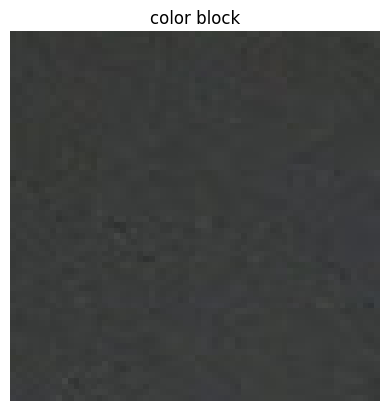

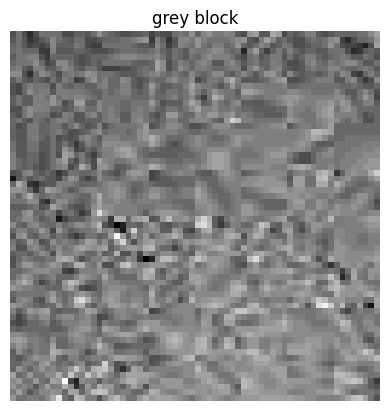

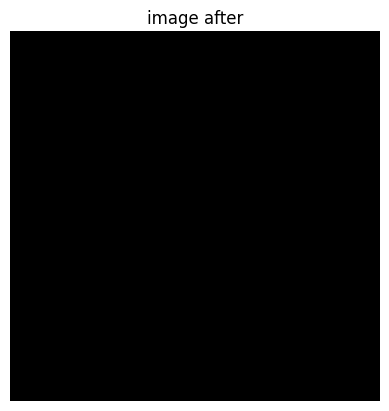

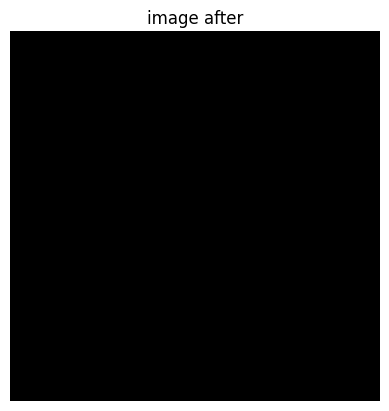

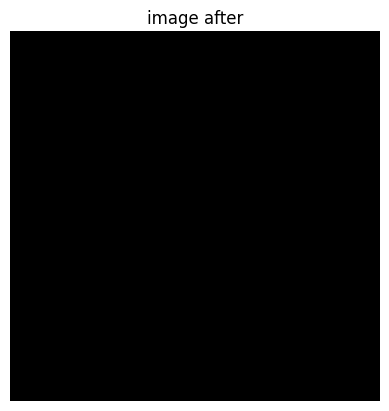

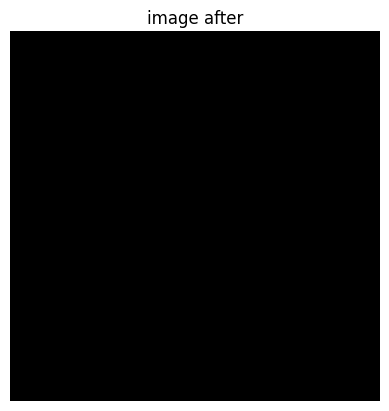

[-0.  0.  1.  0. -0.  0.  1.  0. -0.  0.  1.  0. -0.  0.  1.  0.] 5
0.052978515625 0
0.9296875 5


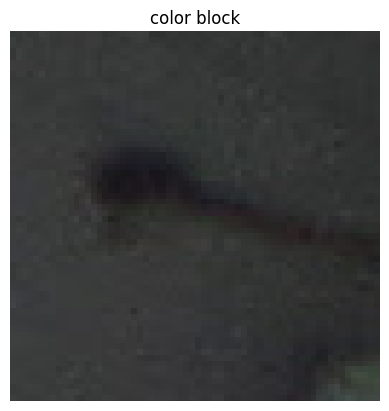

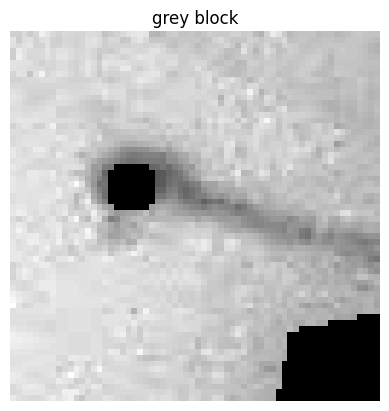

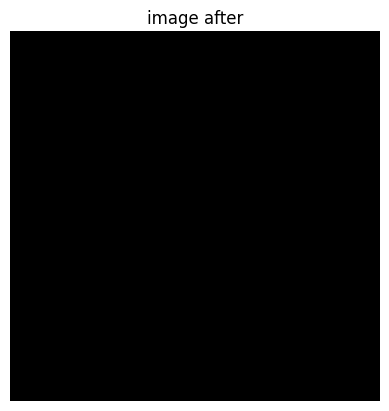

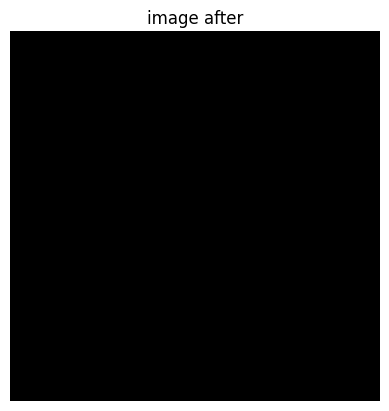

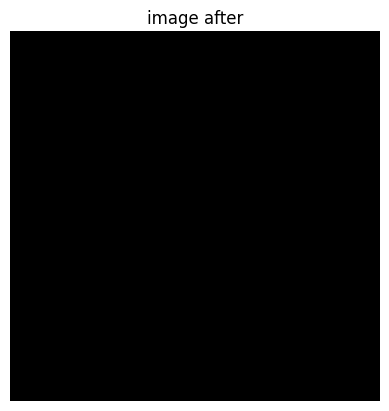

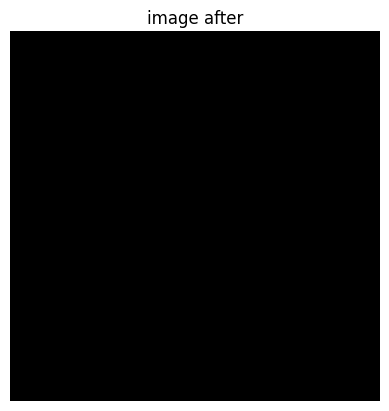

[-0.  0.  1.  0. -0.  0.  1.  0. -0.  0.  1.  0. -0.  0.  1.  0.] 5
0.017333984375 6
0.183837890625 0
0.416259765625 5


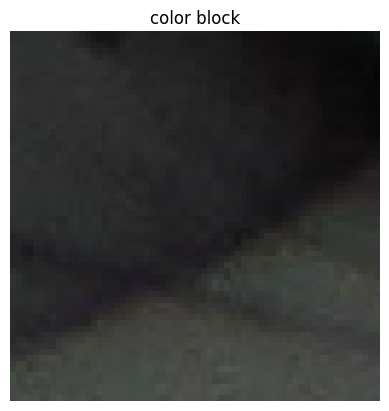

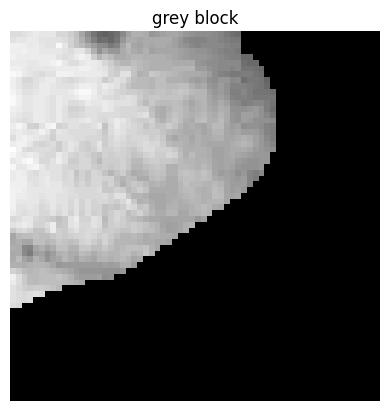

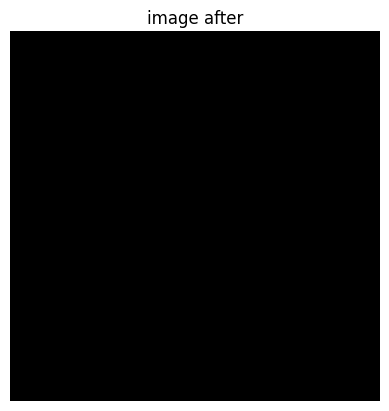

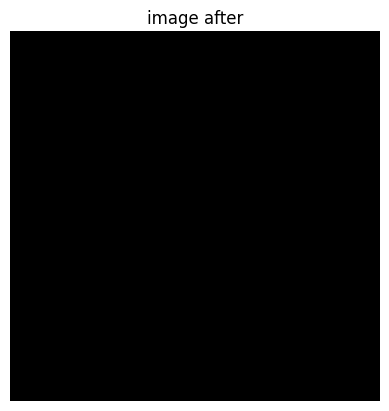

  0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [131]:
model = ColorClusterMockModel(classes=classset)
model.train(img_mask_paths=train_img_mask_p[:1]) # remove limit in future!

Запуск тестирования модели. В демонстрационных целях используются только 3 первых изображений из тестового набора.

In [12]:
from petroscope.segmentation.eval import SegmDetailedTester


tester = SegmDetailedTester(
    Path("output"),
    classes=classset,
    void_pad=0,
    void_border_width=4,
    vis_plots=False,
    vis_segmentation=True,
)

res, res_void = tester.test_on_set(
    test_img_mask_p[:3], # remove limit in future!
    lambda img: model.predict_image(img),
    description="test",
    return_void=True,
)

print(f"Metrics:\n{res}")
print(f"Metrics with void borders:\n{res_void}")

testing: 100%|██████████| 3/3 [00:37<00:00, 12.54s/it]

Metrics:
	 iou [soft]:
		 bg: 0.7866 [0.7866]
		 brt: 0.0000 [0.0000]
		 ccp/kub: 0.2327 [0.2327]
		 gl: 0.0438 [0.0438]
		 py/mrc: 0.4092 [0.4092]
		 sph: 0.3644 [0.3644]
		 tnt/ttr: 0.0096 [0.0096]
	 mean iou [soft]: 0.2638 [0.2638]
	 acc: 0.5923

Metrics with void borders:
	 iou [soft]:
		 bg: 0.8181 [0.8181]
		 brt: 0.0000 [0.0000]
		 ccp/kub: 0.2514 [0.2514]
		 gl: 0.0437 [0.0437]
		 py/mrc: 0.4176 [0.4176]
		 sph: 0.3851 [0.3851]
		 tnt/ttr: 0.0073 [0.0073]
	 mean iou [soft]: 0.2748 [0.2748]
	 acc: 0.6236



В директории ```./output``` по результатам тестирования можете найти визуализацию сегментаций и текстовые файлы со значениями метрик.

## Что нужно теперь сделать?

Вам необходимо реализовать собственный метод автоматической сегментиации минералов. Разработанное решение должно быть оформлено в виде класса, отнаследованного от ```GeoSegmModel``` из пакета ```petroscope``` (как в примере выше).

Обратите внимание, что реализованный класс должен поддерживать автоматическое сохранение и загрузку модели (метод ```load```). Это позволит протестировать решение, не обучая модель заново.

Ваша цель - добиться как можно более высоких показаний метрик сегментации на тестовой выборке (тестовую выборку нельзя использовать при обучении или валидации!), ключевой является метрика mean_iou в режиме void_borders.

Решенные задания присылайте в виде ссылок на github репозиторий, или непосредственно ipynb ноутбуки. Обязательно проверьте воспроизводимость кода, чтобы я мог запустить вашу обученную модель!

<font color="red">
Рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и положить этот pdf в репозиторий вместе с самим ноутбуком.
</font>

Удачи!